In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *

def getFeatureIndexDict(tfidf):
    feature_to_weight = dict()
    feature_name = tfidf.get_feature_names()
    for i, j in enumerate(feature_name):
        feature_to_weight[j] = i
    return feature_to_weight

In [20]:
cls_file_name = "Log_model_1gram.sav"
cls = pickle.load(open(cls_file_name, "rb"))

vectorizer_file_name = "tfidf_1gram.sav"
tfidf = pickle.load(open(vectorizer_file_name, "rb"))

#coeffcients the parameter of the linear regression model
coeffcients = cls.coef_[0]

#feature_to_weight is a map between the word and its index in an array
feature_to_weight = getFeatureIndexDict(tfidf)


In [37]:
Sample_correct = ["this is good .", 1]
Sample_misclassify = ["nothing is wrong .", 1]
Sample_incorrect = ["this is not good .", 0]

negative_sample = ["Worst place ever!!!! Their chicken is horrible pink not fully cooked!!!",0]
positive_sample = ["Simply wonderful, service was attentive, quick and friendly.",1]

Sample = positive_sample


In [38]:
def predictAnalysis(cls, Sample):
    wordVector = tfidf.transform([Sample[0]])
    example_sentence = tfidf.inverse_transform(wordVector)[0]
    output = ""
    prediction = cls.predict(wordVector)
    confidence = cls.predict_proba(wordVector)[0][prediction]
    output += "Prediction: %d with confidence %f. \n" % (prediction, confidence)
    output += "Predictor thinks words: "
    important_word = []
    if prediction == 1:
        for w in example_sentence:
            if cls.coef_[0][feature_to_weight[w]] > 0:
                important_word.append(w)
        for w in important_word:
            output += '(' + w +  '), '
        output += "is positive, thus it predicted Positive. \n"
    else:
        for w in example_sentence:
            if cls.coef_[0][feature_to_weight[w]] < 0:
                important_word.append(w)
        for w in important_word:
            output += '(' + w +  '), '
        output += "is negative, thus it predicted Negative. \n"
    if prediction == Sample[1]:
        output += "Fortunately, it's correct. "
    else:
        output += "Unfortunately, it's incorrect. \n"
        output += "It may be because "
        important_word = []
        if prediction == 0:
            for w in example_sentence:
                if cls.coef_[0][feature_to_weight[w]] > 0:
                    important_word.append(w) 
            for w in important_word:
                output += '(' + w +  '), '
            output += " does not have enough positive weight to make the sentence Positive "
        else:
            for w in example_sentence:
                if cls.coef_[0][feature_to_weight[w]] < 0:
                    important_word.append(w) 
            for w in important_word:
                output += '(' + w +  '), '
            output += " does not have enough negative weight to make the sentence Negative "
        output += "or we have double negation which is hard to classify."
    print(output)
    
predictAnalysis(cls,Sample)

Prediction: 1 with confidence 0.989091. 
Predictor thinks words: (wonderful), (simply), (quick), (friendly), (attentive), (and), is positive, thus it predicted Positive. 
Fortunately, it's correct. 


['and' 'attentive' 'friendly' 'quick' 'service' 'simply' 'was' 'wonderful']


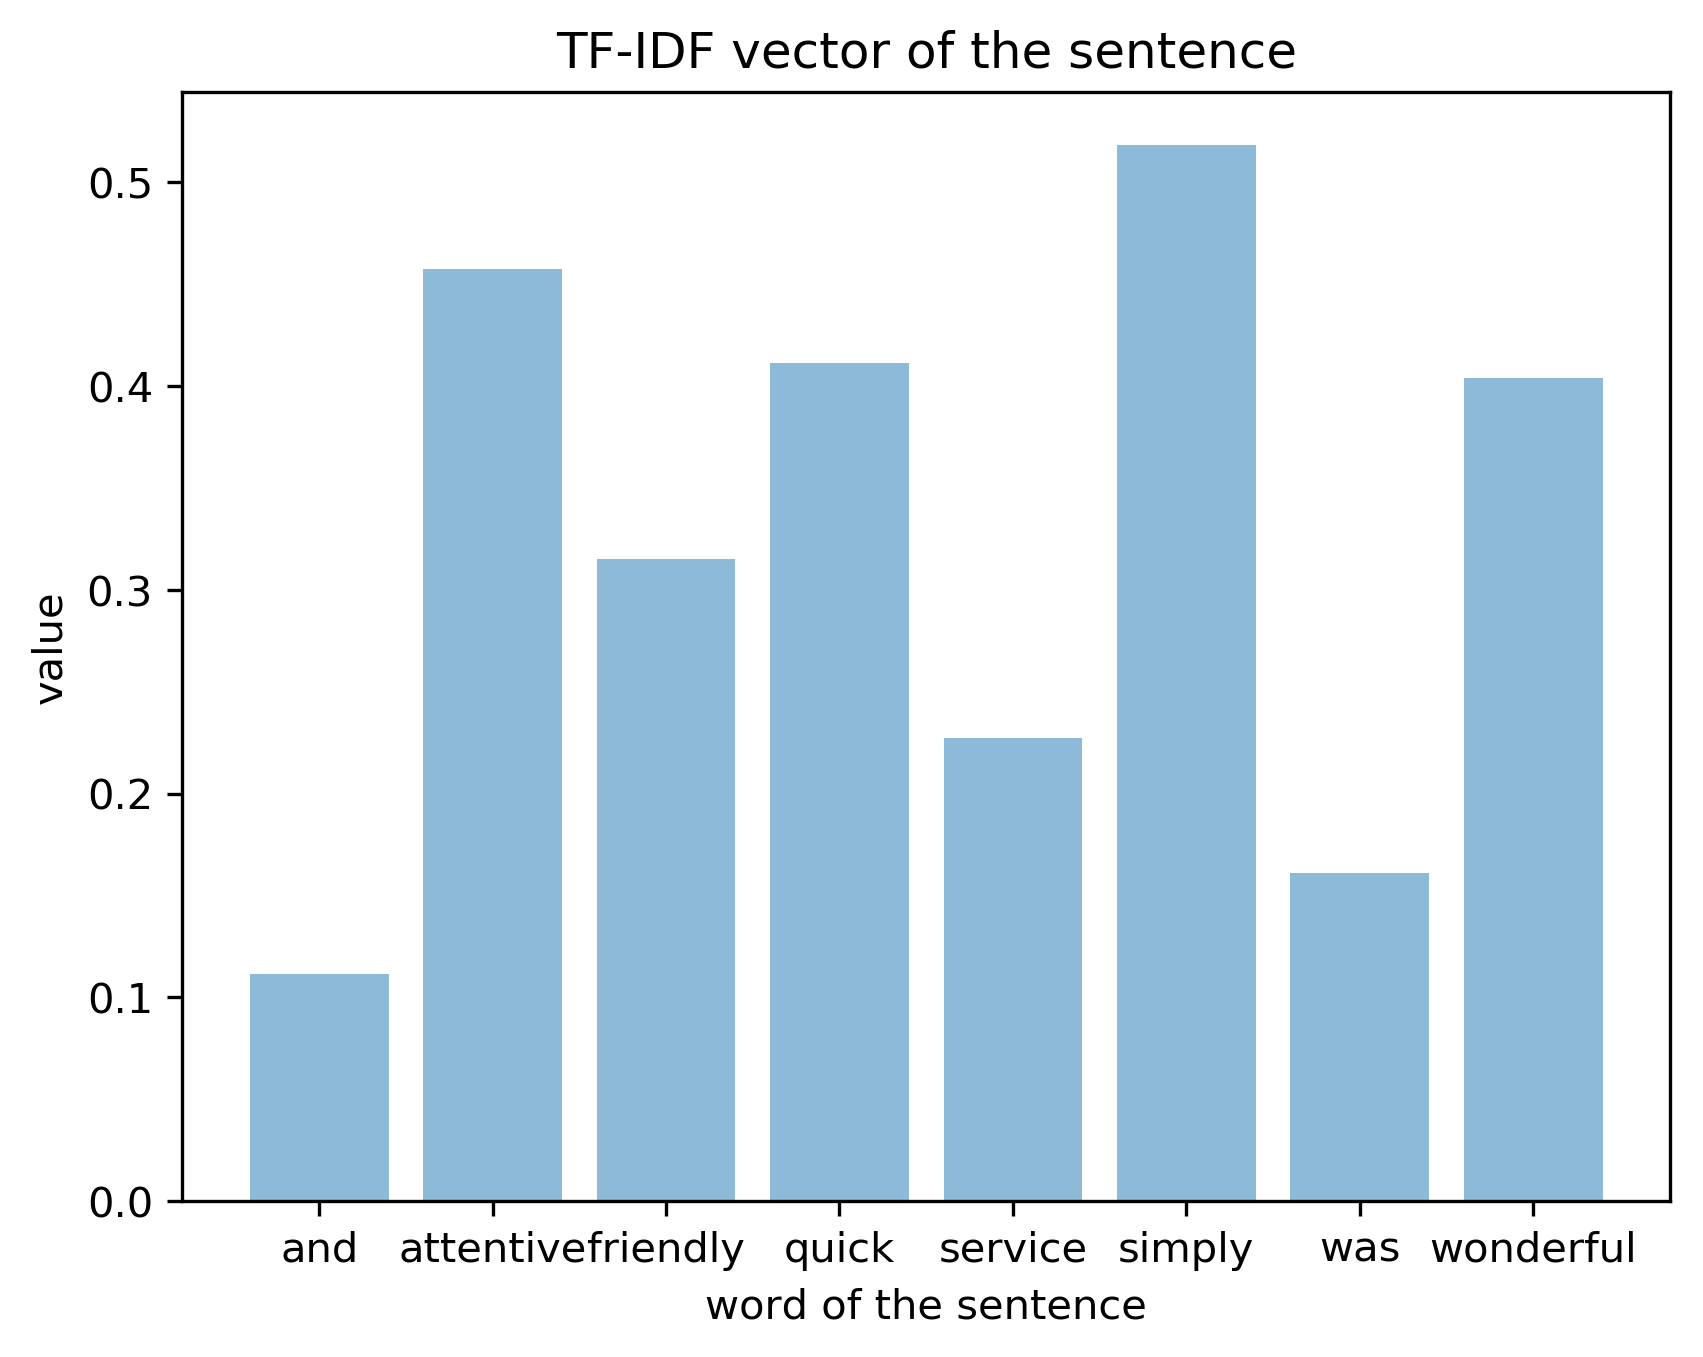

In [39]:
def drawVectorGraph(sentence,tfidf):
    wordVector = tfidf.transform([sentence])[0].toarray()
    example_sentence = tfidf.inverse_transform(wordVector)[0]
    weights = []
    print(example_sentence)
    for i, w in enumerate(example_sentence):
        index = feature_to_weight.get(w, -1)
        if index == -1:
            weights.append(0.0)
        else:
            weights.append(wordVector[0][index])

    objects = example_sentence
    y_pos = np.arange(len(objects))
    performance = weights
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['figure.dpi'] = 300
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('value')
    plt.xlabel('word of the sentence')
    plt.title('TF-IDF vector of the sentence')

    plt.show()
    
drawVectorGraph(Sample[0],tfidf)   

['wonderful' 'was' 'simply' 'service' 'quick' 'friendly' 'attentive' 'and']


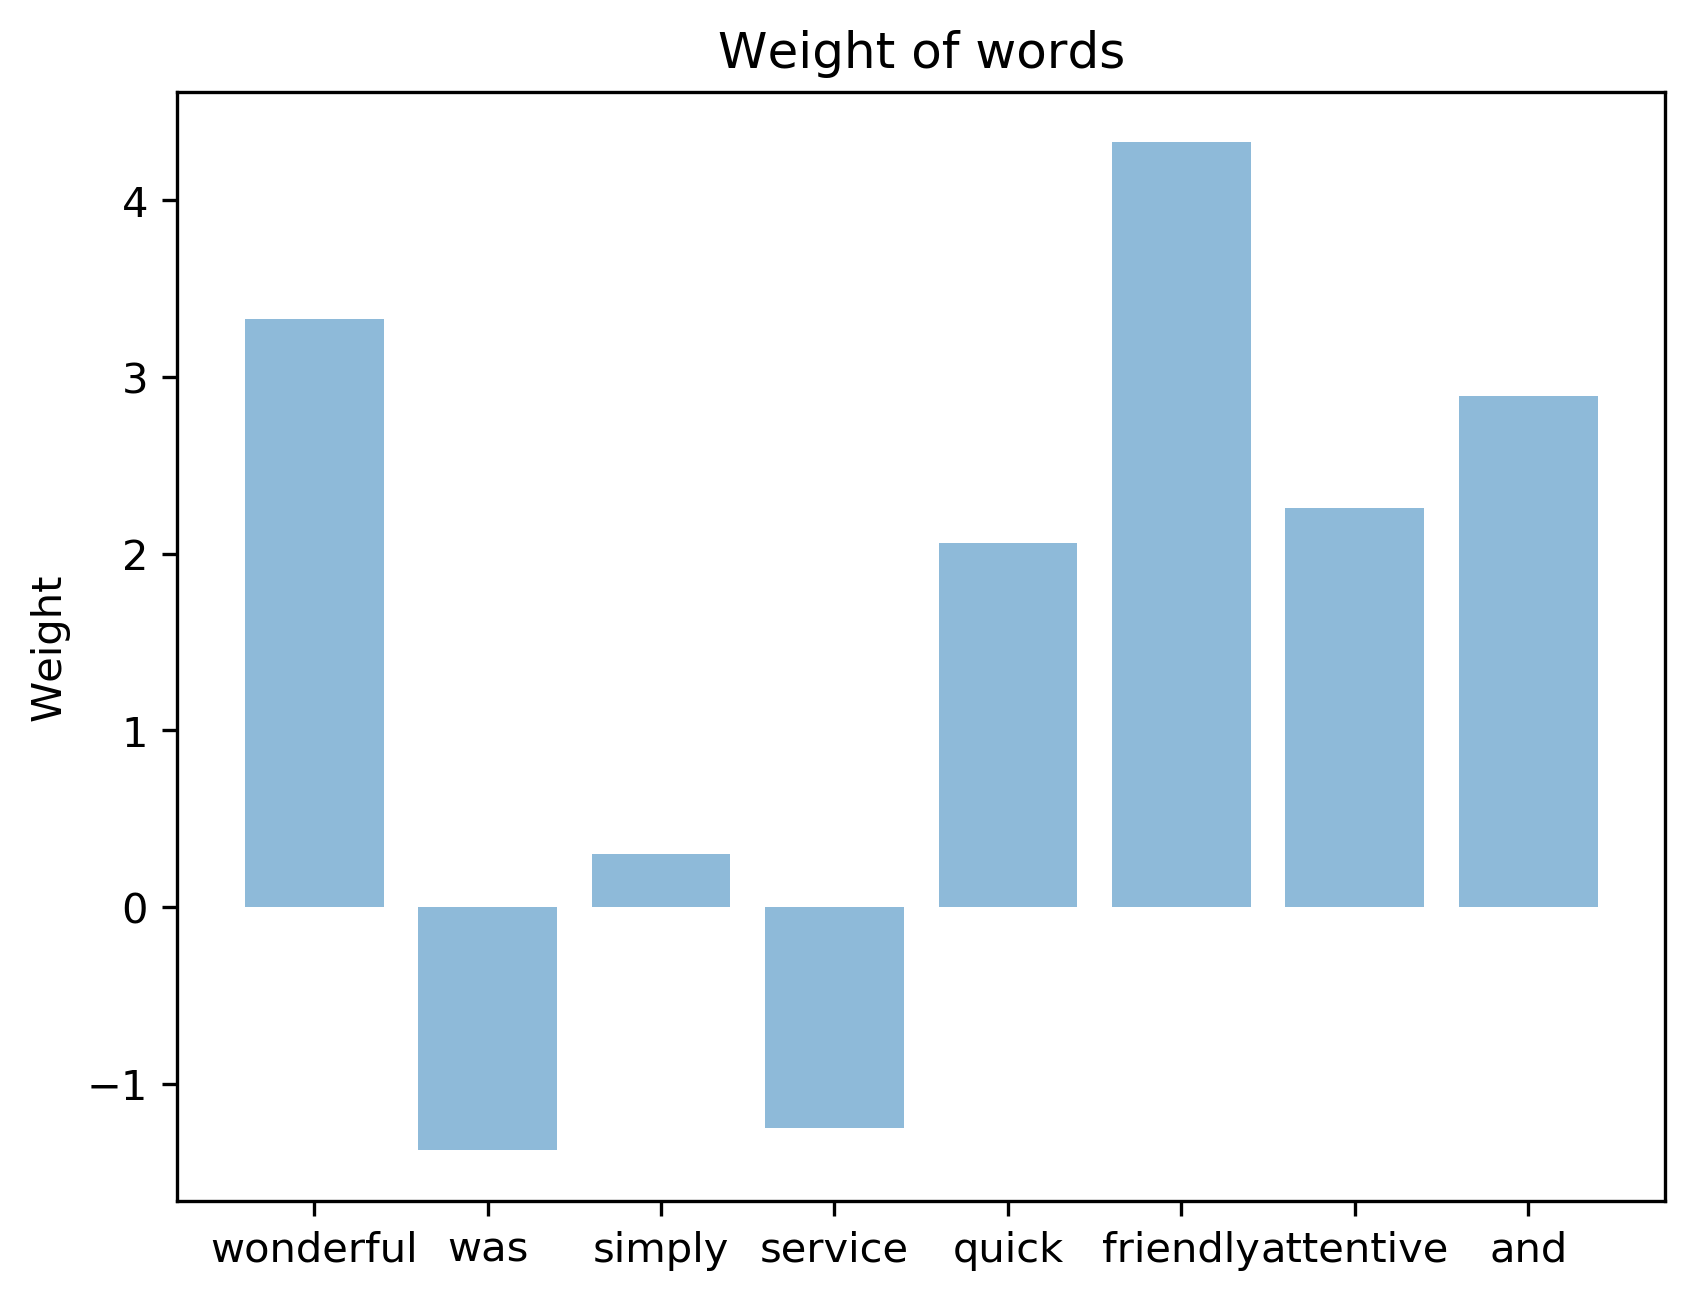

In [40]:
def drawWeightGraph(example_sentence,coeffcients):
    wordVector = tfidf.transform([Sample[0]])
    example_sentence = tfidf.inverse_transform(wordVector)[0]
    
    weights = []
    print(example_sentence)

    for i, w in enumerate(example_sentence):
        index = feature_to_weight.get(w, -1)
        if index == -1:
            weights.append(0.0)
        else:
            weights.append(coeffcients[index])

    objects = example_sentence
    y_pos = np.arange(len(objects))
    performance = weights
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Weight')
    plt.title('Weight of words')
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['figure.dpi'] = 300
    plt.show()
  
# example_sentence = [x for x in example_sentence if len(x.split(" "))<=1]
drawWeightGraph(Sample[0],coeffcients)


In [41]:
def drawWidget(sentence,tfidf):
    temp_cls = pickle.load(open(cls_file_name, "rb"))
    test_ = tfidf.transform([sentence])
    
    a = widgets.FloatText(value =temp_cls.predict_proba(test_)[0][temp_cls.predict(test_)], description='Confidence:' )
    b = widgets.Text(value = "Positive" if temp_cls.predict(test_)== 1 else "Negative" , description='Predicted:' )

    def on_value_change(change):
        temp_cls.coef_[0][feature_to_weight[change['owner'].description]] = change['new']
        b.value = value = "Positive" if temp_cls.predict(test_)== 1 else "Negative"
        a.value = temp_cls.predict_proba(test_)[0][temp_cls.predict(test_)]

    kwarg = {}
    words = tfidf.inverse_transform(tfidf.transform([sentence]))[0]
    for w in words:
        kwarg[w] = widgets.FloatSlider(min= -10.0,max=10.0,step=0.01,value=temp_cls.coef_[0][feature_to_weight[w]], orientation='horizontal', description=w)
        kwarg[w].observe(on_value_change, names = 'value')

    output = []
    for w in kwarg:
        output.append(kwarg[w])

    display(*output)
    display(b)
    display(a)

drawWidget(Sample[0],tfidf)

FloatSlider(value=3.3282717873787635, description='wonderful', max=10.0, min=-10.0, step=0.01)

FloatSlider(value=-1.3772220335985896, description='was', max=10.0, min=-10.0, step=0.01)

FloatSlider(value=0.3013912011658766, description='simply', max=10.0, min=-10.0, step=0.01)

FloatSlider(value=-1.2513062367642398, description='service', max=10.0, min=-10.0, step=0.01)

FloatSlider(value=2.0612687260164053, description='quick', max=10.0, min=-10.0, step=0.01)

FloatSlider(value=4.328532000284189, description='friendly', max=10.0, min=-10.0, step=0.01)

FloatSlider(value=2.260172587328263, description='attentive', max=10.0, min=-10.0, step=0.01)

FloatSlider(value=2.8933114068449983, description='and', max=10.0, min=-10.0, step=0.01)

Text(value='Positive', description='Predicted:')

FloatText(value=0.9890908579921311, description='Confidence:')